In [1]:
#Run this cell so the rest of the code can work!
import warnings
warnings.filterwarnings('ignore') #ignores any warning that appear from libraries, e.g. seaborn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso #ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

### Notes to consider for the challenge

1. Pre-process the data is somewhat complete, though we may need to confirm between the group to check if this is the best representation of data.
 - We found the mean of each column from the data base (Concrete_Data_Yeh_final.csv) - but is this the right approach?

2. Check the correlation between each input variable and Compressive strength, having filled all NaN values. Use unscaled data, we just want to know what the current trend is and apply a reasonable transformation that best describes the relationship for the regression models.
- This might need to go back to step 1, but try to use another alternative for the NaN values - e.g. using mode, mean or could just remove the row as a whole?

3. Given our predictions from the regression model algorithms, how can we transfer or represent this data to the interactive plot (what Felix has been working on)? This might require gathering coefficients for the sliding scale graph.

In [2]:
filename = 'Concrete_Data_Yeh_final.csv'
variables = ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age']

class PreProcessing:
    "The aim of this class is to successfully replace all the empty values from"
    "the file given, and to split the columns into their own series / arrays."
    def __init__(self, file):
        self.data = pd.read_csv(file)
        
    def checkNaN (self):
        return self.data.isnull().sum()
    
    def FillNaN (self) -> pd.DataFrame:
        # Here we used the .fillna method to replace the NaN values with the mean of the variable.
        # We checked this by plotting the graphs in the following code and using the DataFrame produced comparing mean and median and gradient (for a linear relationship).
        for variable in self.data.columns[:-1]:
            self.data[variable].fillna(self.data[variable].mean(), inplace = True)
            if variable == 'age': # ['cement', 'water', 'fineaggregate', 'coarseaggregate']
                self.data[variable] = np.log(self.data[variable])
            if variable in ['cement', 'superplasticizer']:
                self.data[variable] = self.data[variable].apply(lambda x: np.sqrt(x))
            elif variable == 'water':
                self.data[variable] = self.data[variable].apply(lambda x: 1/x)
            else:
                continue
        return self.data
    
    def removeNaN (self) -> pd.DataFrame:
        # Here we used the .dropna method to remove the NaN values from the original dataset (if needed).
        self.data.dropna(inplace = True)
        for variable in self.data.columns[:-1]:
            if variable in ['cement', 'water', 'age', 'fineaggregate', 'coarseaggregate']:
                self.data[variable] = np.log(self.data[variable])
        return self.data


'''test = PreProcessing(filename).removeNaN()
test2 = PreProcessing(filename).FillNaN()'''
#test = PreProcessing(filename).checkNaN()
#print(test)
concretedata = PreProcessing(filename).FillNaN()
concretedata.head(5)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,23.237900,0.0,0.0,0.006173,1.581139,1040.0,676.0,3.332205,79.99
1,23.237900,0.0,0.0,0.006173,1.581139,1055.0,676.0,3.332205,61.89
2,18.234583,142.5,0.0,0.004386,0.000000,932.0,594.0,5.598422,40.27
3,18.234583,142.5,0.0,0.004386,0.000000,932.0,594.0,3.816114,41.05
4,14.092551,132.4,0.0,0.005208,0.000000,978.4,825.5,5.886104,44.30


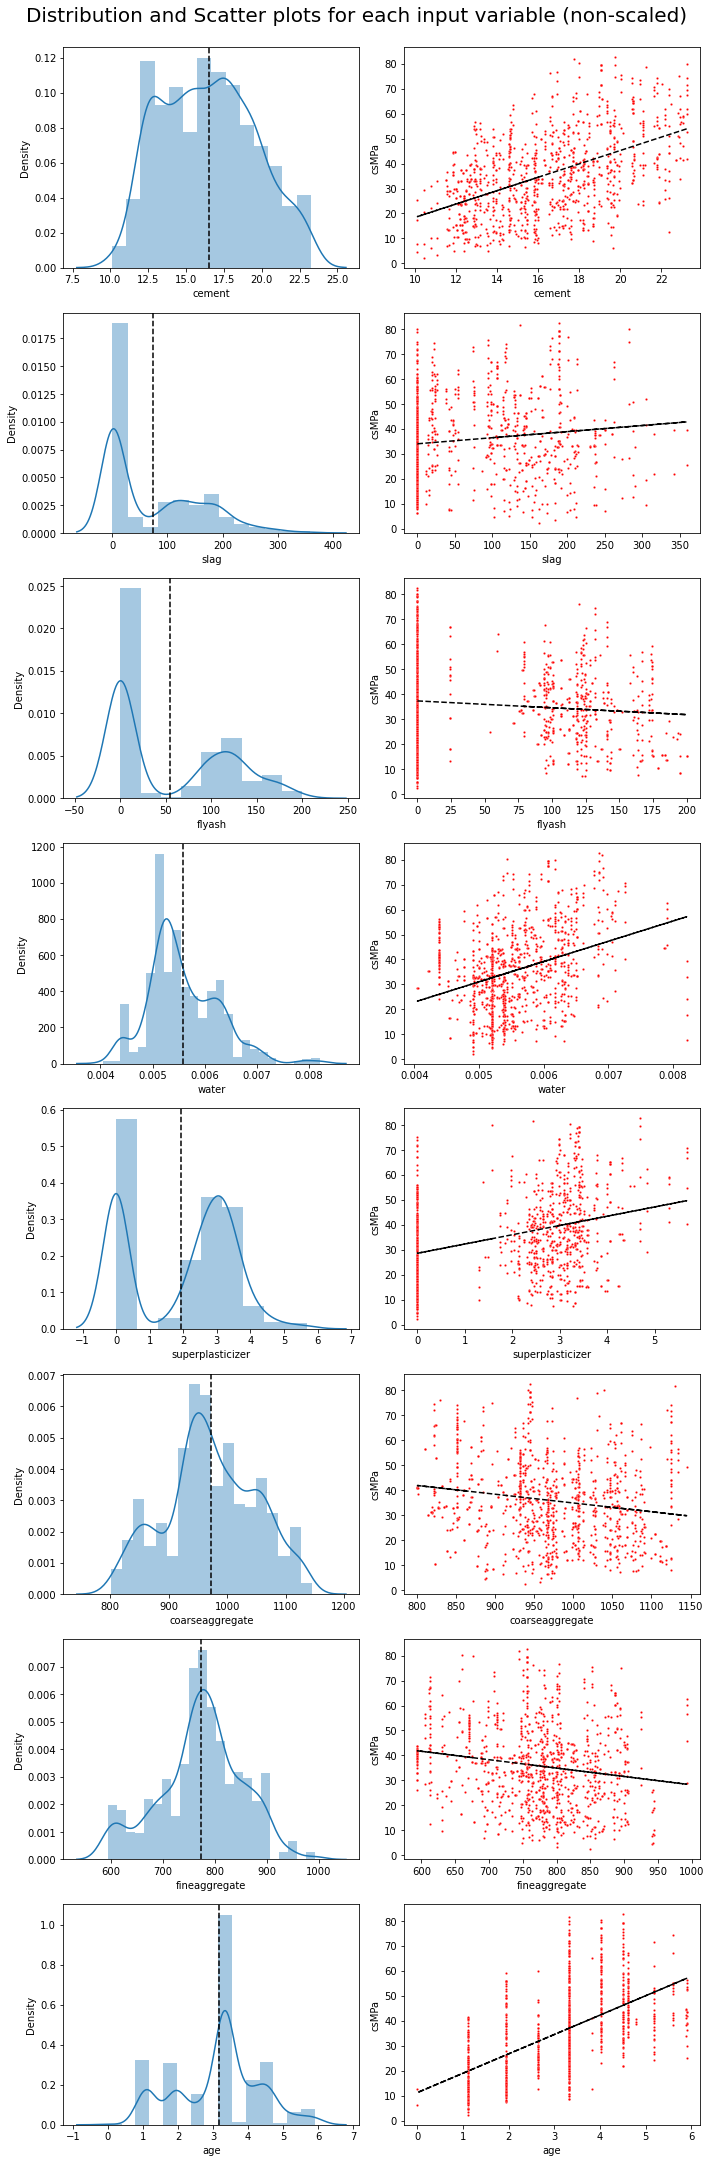

,Variables,Mean,Median,Gradient
0,cement,16.479268,16.519685,2.675611
1,slag,73.668652,22.000000,0.024389
2,flyash,54.122838,0.000000,-0.027461
3,water,0.005586,0.005405,8121.943295
4,superplasticizer,1.944439,2.519901,3.711532
5,coarseaggregate,972.653959,968.000000,-0.035132
6,fineaggregate,773.698150,779.300000,-0.033615
7,age,3.169721,3.332205,7.754549


In [3]:
fig, axs = plt.subplots(8, 2, figsize=(10, 30))
fig.suptitle('Distribution and Scatter plots for each input variable (non-scaled)', y = 1, fontsize = 20)

dict = {'Variables': [], 'Mean': [], 'Median':[] , 'Gradient': []}

for i, input in enumerate(concretedata.columns[:-1]):
    dict['Variables'].append(input)

    sns.distplot(concretedata[input], ax=axs[i, 0])
    axs[i,0].axvline(concretedata[input].mean(),linestyle="dashed",label="mean", color='black')
    dict['Mean'].append(concretedata[input].mean())
    dict['Median'].append(concretedata[input].median())

    sns.scatterplot(x=concretedata[input], y=concretedata['csMPa'], ax=axs[i, 1], color = 'red', s = 5)
    m,b = np.polyfit(concretedata[input], concretedata['csMPa'], 1)
    axs[i,1].plot(concretedata[input], m*concretedata[input] + b, color='black', linestyle= 'dashed')
    dict['Gradient'].append(m)

plt.tight_layout()
plt.show()
pd.DataFrame(dict)

### What does this information tell me?

1. Cement, water, coarseaggregate and fineaggregate generally follow a gaussian distribution. For pre-processing, it would be most appropriate to fill any NaN values with their respective mean for optimum regression performance.

2. Slag, flyash and superplasticizer have irregular gaussian patterns - this its mainly due to the amount of 0 values in their variable data, which it will likely lead to skewed data for regression. Using their respective scatter plots, it means that the true gradient isnt correct. Further research in real sources could aid getting a more predictive result in the end.
But how are we going to deal with this?
- One idea I have in mind is to find an averaged value for csMPa for the variable data (slag, flyash and superplasticizer) that contain a 0 value. Yes this does mean slightly less data overall with respect to that variable, but will lead to higher and more precise regressions because the Gaussian will be more defined. **this has not been done yet!**

3. Age is slighlty more complex. Having spoken with Felix, he says that using a logarithmic scale in pre-processing would be the best approach. This can be backed up because looking at the graph of csMPa vs age (literal values), the gradient can not provide an accurate representation of the relationship between these two variables.

### Actions done:
1. Tried using mode - this further skews the data, since slag, flyash and superplasticiser have modes of 0.
2. Mean is quite appropriate, skewness still occurs with these 3 variables mentioned above.
3. Median does reduce the skewness slightly because there aren't that many NaN values to fill. We should not changed any existing in any way otherwise we can be introducing bias.

Final action taken - the mean was used for the following variables. After looking at resources (including previously published reports,linked at end of code), the following variables were amended in pre-processing:
- Cement and Superplasticizer took a square root transformation, as they plateau towards high values.
- Water took a reciprocal transformation, as there was evident negative correlation with compressive strength.
- Age took a logarithmic transformation, as suggested by Felix from a resource.


## Scaling and Splitting data into training and test sets
We will scale variables via MinMaxScaler (from sklearn.PreProcessing) so that all variables are comparable under the same axis. It is better to scale such data before performing regression or any other machine learning algorithms that may follow. The shape of these data sets has been included as well to see how the numbers have adjusted via the training ratio.

After iterating the code, we find out that $\alpha$ = 0.15 provided the optimal regressions, without under or overfitting the data.

In [4]:
# Create a scaler
scaler = MinMaxScaler()

# Split the DataFrame into training and testing sets - train_test_split is a function from sklearn.
X = concretedata.iloc[:,:-1].to_numpy() 
y = concretedata['csMPa'].to_numpy()

print(f'y:\n{y}\n')
print(f'X:\n{pd.DataFrame(X)}\n') # to check if the data is split correctly (X = 2D array, y = 1D array).
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

y:
[79.99 61.89 40.27 ... 23.7  32.77 32.4 ]

X:
              0      1      2         3         4       5      6         7
0     23.237900    0.0    0.0  0.006173  1.581139  1040.0  676.0  3.332205
1     23.237900    0.0    0.0  0.006173  1.581139  1055.0  676.0  3.332205
2     18.234583  142.5    0.0  0.004386  0.000000   932.0  594.0  5.598422
3     18.234583  142.5    0.0  0.004386  0.000000   932.0  594.0  3.816114
4     14.092551  132.4    0.0  0.005208  0.000000   978.4  825.5  5.886104
...         ...    ...    ...       ...       ...     ...    ...       ...
1025  16.625282  116.0   90.3  0.005568  2.983287   870.1  768.3  3.332205
1026  17.949930    0.0  115.6  0.005102  3.224903   817.9  813.4  3.332205
1027  12.186058  139.4  108.6  0.005189  2.469818   892.4  780.0  3.332205
1028  12.613485  186.7    0.0  0.005695  3.361547   989.6  788.9  3.332205
1029  16.152399  100.5   78.3  0.004985  2.932576   864.5  761.5  3.332205

[1030 rows x 8 columns]



In [5]:
# To check if the general shape of both the training and testing sets are reasonable. This can be adjusted if bias is found. #
print(y_test.shape, y_train.shape, x_test.shape, x_train.shape)

(155,) (875,) (155, 8) (875, 8)


## Building the Regression Model
The Regression model is a class; the __init__ function will set out the train/test sets, as well as performing the regressions for the predictions and regression fit with the training and test data respectively. The following codes after this are looped to go through each regression to determine which of the 4 (*maybe 5?*) regressions work best using our pre-processed data.

The Metrics function allows to observe the regression performances. Here we used 3 different methods: Regression score, Root mean squared error (RMSE) and cross validation. Despite cross validation typically used for classification methods (which we dont use at all in this challenge), it has been used for regression to find the true mean of the regression, had it been repeated several times with the given training/test data.

Finally, the Plot function is a visual aid to show the trend between the predicted and actual data given our pre-processed training and test data. This is beneficial for us to see how accurate and comparable our predicted data is - the higher the regression score, the better. For reference, the dashed black line is the ideal proportionality between the two.


In [6]:
class RegressionModel:
    def __init__(self, x_train, x_test, y_train, y_test, regression, **kwargs): #input if needed: metriclist = list
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.regression = regression(**kwargs)
        self.regfit = self.regression.fit(x_train, y_train)
        self.y_pred = self.regression.predict(x_test)
        # self.y_pred is a numpy array that gives a predicted value of y for each x in x_test, given the fit of the trained model.
    
    def Metric(self, metric, **kwargs):
        #scores = cross_val_score(self.regression, self.x_train, self.y_train, cv=5)
        #print(metric(self.y_test, self.y_pred))
        #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        return metric(self.y_test, self.y_pred), self.regression.score(self.x_test, self.y_test)

    def Plot(self, **kwargs):
        ref_x = np.linspace(0, 80, 1000)
        ref_y = ref_x
        plt.figure(figsize=(6, 4))
        plt.scatter(self.y_test, self.y_pred, color='red', s=5)
        plt.title(f'Score: {self.regression.score(self.x_test, self.y_test)}')
        plt.plot(ref_x, ref_y, color='black', linestyle = 'dashed')
        plt.xlabel('Actual csMPa')
        plt.ylabel('Predicted csMPa')
        plt.show()
        return

Using LinearRegression


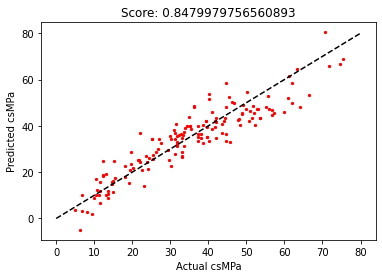

Using Ridge


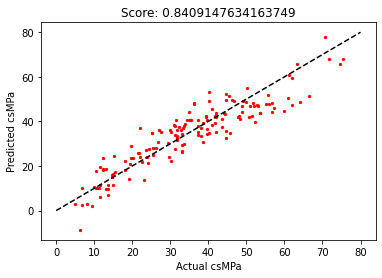

Using Lasso


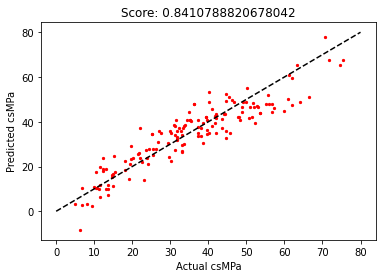

Using RandomForestRegressor


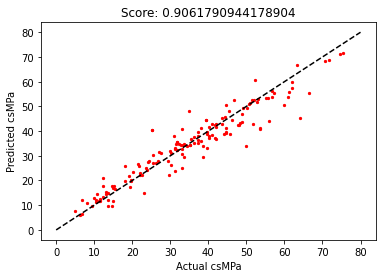

In [7]:
regressors = [LinearRegression, Ridge, Lasso, RandomForestRegressor] # ElasticNet cant provide a better output than either ridge or lasso.
metrics = [lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), mean_squared_error, r2_score, mean_absolute_error, explained_variance_score]

for i, r in enumerate(regressors):
    print(f'Using {r.__name__}')
    if i == 0:
        RegressionModel(x_train, x_test, y_train, y_test, r).Plot()
    elif i in [1, 2]:
        RegressionModel(x_train, x_test, y_train, y_test, r, alpha = 0.1, random_state = 42).Plot()
    else:
        RegressionModel(x_train, x_test, y_train, y_test, r, n_estimators = 200, max_depth = 30, random_state = 42).Plot()

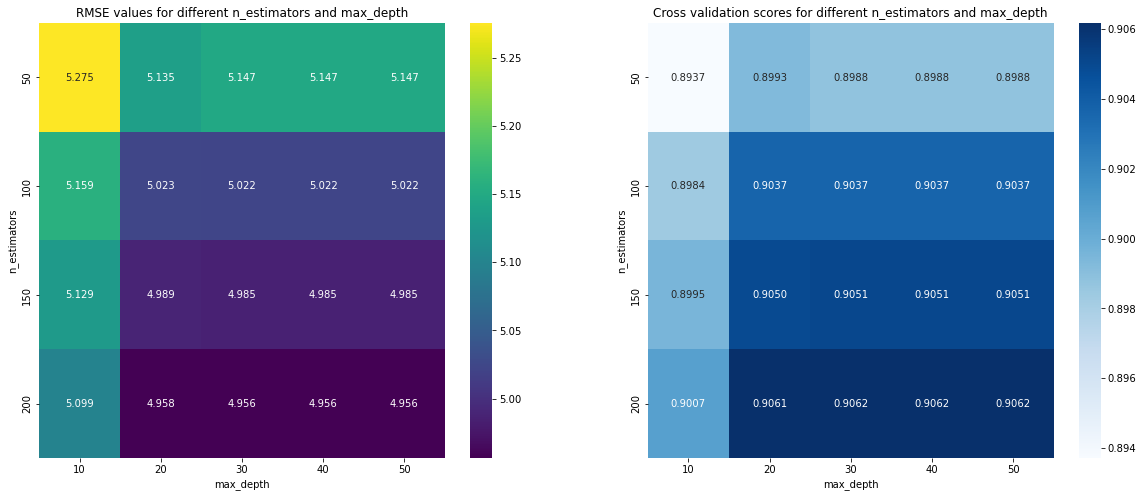

In [8]:
'''Using just Random Forest - only operate if needed! This bit will take longer than usual to run.'''
rmse_values = [[0 for _ in range(5)] for _ in range(4)] #2D array
score_values = [[0 for _ in range(5)] for _ in range(4)] #2D array

for i, n_estimators in enumerate([50,100,150,200]):
    for j, max_depth in enumerate([10,20,30,40,50]):
        #print(f'n_estimators = {n_estimators}, max_depth = {max_depth}')
        rmse, scoring = RegressionModel(x_train, x_test, y_train, y_test, RandomForestRegressor, n_estimators = n_estimators, max_depth = max_depth, random_state = 42).Metric(metrics[0])
        rmse_values[i][j] = rmse
        score_values[i][j] = scoring

# Convert the 2D list to a DataFrame
rmse_df = pd.DataFrame(rmse_values, index=[50,100,150,200], columns=[10,20,30,40,50])
score_df = pd.DataFrame(score_values, index=[50,100,150,200], columns=[10,20,30,40,50])

# Create the heatmap
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
#RMSE heatmap
sns.heatmap(rmse_df, annot=True, fmt=".3f", cmap='viridis', ax = axs[0])
axs[0].set_title('RMSE values for different n_estimators and max_depth')
axs[0].set_xlabel('max_depth')
axs[0].set_ylabel('n_estimators')

#Score heatmap
sns.heatmap(score_df, annot=True, fmt=".4f", cmap='Blues', ax = axs[1])
axs[1].set_title('Cross validation scores for different n_estimators and max_depth')
axs[1].set_xlabel('max_depth')
axs[1].set_ylabel('n_estimators')

plt.show()

## Observations from this Model
To start, this code works well with all regression models. But it was the Random Forest regression that outperformed all other models, using hyperparameters of n_estimators and max_depth. After realising this, the looped code above provided a heatmap to find the combination of estimators/depth that provided the highest regression score and lowest rmse, which resulted in n_estimators = 200 and max_depth = 30.

I took out age from the training set to see the changes, and it reduced the scores of each regression by nearly half - this is likely the feature that is most important to obtain a good prediction.

### Whats next?
Try playing around with the Pre-processing stuff, I made a bunch of comments there that justified my decisions with variables using the mean or median. Some variables may also require to perform a log, but please check everything out if this is ok!

According to this website I found, the code now provides a 'Very Good' score! We can keep improving this if we can find the best trends within each input variable of the csv file. If this can be sorted out, we can pass the information over to the interactive graph.

Reference link: https://stephenallwright.com/good-accuracy-score/#:~:text=There%20is%20a%20general%20rule%20when%20it%20comes,and%2070%25%20-%20OK%20Below%2060%25%20-%20Poor

Let me know of any changes or anything you have in mind <3
Mervyn